<a href="https://colab.research.google.com/github/BenxiaHu/Python/blob/master/Compartment_HiC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 1. Simulate a Hi-C Contact Matrix (M)

In [11]:
# For demonstration, we'll create a small NxN matrix with some artificial structure
N = 1000  # number of bins
np.random.seed(42)  # for reproducibility

# Generate a random matrix
M_raw = np.random.poisson(lam=50, size=(N, N)).astype(float)
# Make it symmetric (real Hi-C is approximately symmetric)
M_raw = 0.5 * (M_raw + M_raw.T)

# 2. Compute the Observed/Expected (O/E) Matrix

# 2.1. Calculate the diagonal averages

In [12]:
diag_sums = np.zeros(N)
diag_counts = np.zeros(N)
for i in range(N):
    for j in range(N):
        d = abs(i - j)
        diag_sums[d] += M_raw[i, j]
        diag_counts[d] += 1

diag_avgs = diag_sums / diag_counts

# 2.2. Build the O/E matrix

In [13]:
O_matrix = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        d = abs(i - j)
        expected = diag_avgs[d]
        if expected == 0:
            O_matrix[i, j] = 0
        else:
            O_matrix[i, j] = M_raw[i, j] / expected

# 3. Z-score Normalization of Rows

In [14]:
# For compartment analysis, it's common to transform each row (or row+column)
# so that each bin's row has mean=0 and std=1.

O_zscore = np.zeros((N, N))
for i in range(N):
    row = O_matrix[i, :]
    row_mean = row.mean()
    row_std = row.std(ddof=1)  # sample standard deviation
    # Avoid division by zero
    if row_std == 0:
        O_zscore[i, :] = 0
    else:
        O_zscore[i, :] = (row - row_mean) / row_std

# 4. Compute the Correlation Matrix (C)

In [15]:
# We'll compute the correlation between row vectors of O_zscore.
C = np.corrcoef(O_zscore)  # shape: NxN

# 5. PCA on the Correlation Matrix

In [16]:
eigenvals, eigenvecs = np.linalg.eig(C)
idx_sorted = np.argsort(eigenvals)[::-1]
eigenvals = eigenvals[idx_sorted]
eigenvecs = eigenvecs[:, idx_sorted]

PC1 = eigenvecs[:, 0].real  # first principal component
compartments = np.where(PC1 > 0, 'A', 'B')  # simple A/B call by sign of PC1

In [17]:
# 6. Create a DataFrame for Easy Plotting

In [18]:
df = pd.DataFrame({
    'bin': np.arange(N),
    'PC1': PC1,
    'compartment': compartments
})


# 7. Plot the results

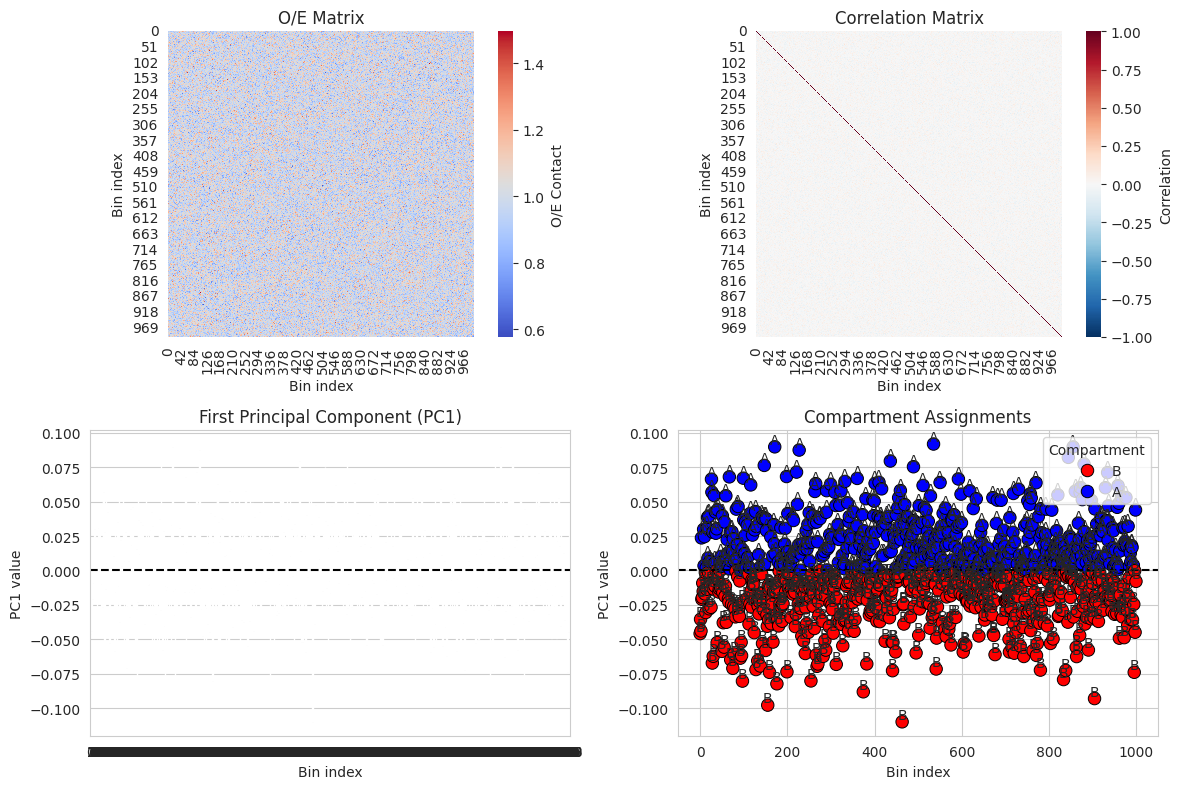

In [19]:
sns.set_style("whitegrid")

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# (A) O/E Matrix Heatmap
sns.heatmap(
    O_matrix,
    cmap='coolwarm',
    ax=axs[0, 0],
    cbar_kws={'label': 'O/E Contact'},
    square=True
)
axs[0, 0].set_title("O/E Matrix")
axs[0, 0].set_xlabel("Bin index")
axs[0, 0].set_ylabel("Bin index")

# (B) Correlation Matrix Heatmap
sns.heatmap(
    C,
    cmap='RdBu_r',
    vmin=-1,
    vmax=1,
    ax=axs[0, 1],
    cbar_kws={'label': 'Correlation'},
    square=True
)
axs[0, 1].set_title("Correlation Matrix")
axs[0, 1].set_xlabel("Bin index")
axs[0, 1].set_ylabel("Bin index")

# (C) PC1 Bar Plot
sns.barplot(
    x='bin',
    y='PC1',
    data=df,
    color='gray',
    ax=axs[1, 0]
)
axs[1, 0].axhline(0, color='black', linestyle='--')
axs[1, 0].set_title("First Principal Component (PC1)")
axs[1, 0].set_xlabel("Bin index")
axs[1, 0].set_ylabel("PC1 value")

# (D) Compartment Assignments (Scatter)
sns.scatterplot(
    x='bin',
    y='PC1',
    hue='compartment',
    data=df,
    palette={'A': 'blue', 'B': 'red'},
    edgecolor='black',
    s=80,
    ax=axs[1, 1]
)
axs[1, 1].axhline(0, color='black', linestyle='--')
axs[1, 1].set_title("Compartment Assignments")
axs[1, 1].set_xlabel("Bin index")
axs[1, 1].set_ylabel("PC1 value")
axs[1, 1].legend(title="Compartment", loc='upper right')

# Optionally, label each point with its compartment letter
for i in range(N):
    axs[1, 1].text(
        df['bin'][i],
        df['PC1'][i],
        df['compartment'][i],
        ha='center',
        va='bottom'
    )

plt.tight_layout()
plt.show()